##### In this notebook I going to work with sample data from dog breed inentification competiotion (images only of 2 breeds present in sample data) 

In [118]:
import os, sys
#current_dir = os.getcwd()
DATA_HOME_DIR =  '/home/denys/projects/ml-models/kaggle/dog-breed-identification/data/'
#DATA_HOME_DIR =  '/home/denys/projects/ml-models/kaggle/dog-breed-identification/data/sample/'

In [119]:
from glob import glob
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold

from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.models import Sequential
from keras.models import Model
from keras.optimizers import Adam

from keras.regularizers import l2

In [120]:
%matplotlib inline

import numpy as np

from keras.preprocessing import image
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold


import utils; reload(utils)
from utils import plot_learning_curve

In [121]:
labels_df = pd.read_csv("data/labels.csv")

def get_breed(id):
    return labels_df.loc[labels_df["id"] == id]["breed"].values[0]

In [122]:
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

In [33]:
target_size=(244,244)

def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, batch_size=4, class_mode='categorical',
                target_size=target_size):
    return gen.flow_from_directory(dirname, target_size=target_size, 
                                   class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

def get_data(path):
    batches = get_batches(path, shuffle=False, batch_size=1, class_mode=None)
    return np.concatenate([batches.next() for i in range(batches.samples)])

In [8]:
train_data = get_data(DATA_HOME_DIR+'train')

Found 9225 images belonging to 120 classes.


In [10]:
save_array(DATA_HOME_DIR+'train_244_244.data', train_data)

In [7]:
train_data = load_array(DATA_HOME_DIR+'train_244_244.data')

In [123]:
batches = get_batches(DATA_HOME_DIR + 'train', shuffle=False, batch_size=1)

Found 9225 images belonging to 120 classes.


In [124]:
def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

In [125]:
train_classes = batches.classes
train_labels = onehot(train_classes)
train_filenames = batches.filenames
train_class_indices = batches.class_indices

In [11]:
model_path = DATA_HOME_DIR + "models/"

In [10]:
def model():
    model = Sequential([
            BatchNormalization(axis=1, input_shape=(224,224, 3)),
            Conv2D(32,(3,3), activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3,3)),
            Conv2D(64,(3,3), activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3,3)),
            Conv2D(128,(3,3), activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3,3)),
            Flatten(),
            BatchNormalization(),
            Dense(2, activation='softmax')
        ])
    model.compile(Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [11]:
def train(model, batches, val_batches, initialisation=False):
    if initialisation:
        model.compile(Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
        model.fit_generator(batches, steps_per_epoch=batches.n / batch_size, epochs=10, validation_data=val_batches, 
                    validation_steps=val_batches.n, verbose=1, callbacks=[csv_logger])

    model.optimizer.lr = 0.00001
    model.fit_generator(batches, steps_per_epoch=batches.n / batch_size, epochs=100, validation_data=val_batches, 
                        validation_steps=val_batches.n, verbose=1, callbacks=[csv_logger])

In [20]:
kf = KFold(n_splits=3, shuffle=True, random_state=1)
kf.get_n_splits(train_data)
print(kf) 

batch_size=10

base_model = model()

init = False
for train_index, valid_index in kf.split(train_data):
    print train_index, valid_index
    train_split, valid_split = train_data[train_index], train_data[valid_index]
    train_labels_split, valid_labels_split = train_labels[train_index], train_labels[valid_index]

    batches = image.ImageDataGenerator(rotation_range=15, width_shift_range=0.1, 
                               height_shift_range=0.1, zoom_range=0.2, horizontal_flip=True).flow(train_split, train_labels_split, batch_size=batch_size, shuffle=True)
    val_batches = image.ImageDataGenerator().flow(valid_split, valid_labels_split, batch_size=batch_size, shuffle=False)
    
    train(base_model, batches, val_batches, init)
    init = False

KFold(n_splits=3, random_state=1, shuffle=True)


TypeError: __call__() takes exactly 2 arguments (1 given)

In [24]:
base_model.save_weights(model_path[:-len("models/sample/")] + "models/new_model_sample.weights")

In [ ]:
valid_data, valid_labels, valid_filenames, valid_class_indices 

In [29]:
valid_class_indices

{'doberman': 0, 'pomeranian': 1}

In [17]:
base_model.test_on_batch(valid_data, valid_labels)

[0.21754244, 0.9333334]

Seems that simple model was not able capture all usefull properties of data, 
so I tried to create more complicated model with 3 convolution layers and was right my test accuracy is 0.93 now

Now lets try transfered learning with next models:
    >VGG16
    >ResNet50
    >InceptionV3
    >InceptionResNetV2
    >MobileNet

In [12]:
from keras.callbacks import CSVLogger
csv_logger = CSVLogger('vgg16_0130_1611.log', append=True)

batch_size=10
kf = KFold(n_splits=3, shuffle=True, random_state=1)
kf.get_n_splits(train_data)
print(kf) 

KFold(n_splits=3, random_state=1, shuffle=True)


In [126]:
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.mobilenet import MobileNet

# = {"vgg16": VGG16(weights='imagenet', include_top=False),
         # "resnet50" : ResNet50(weights='imagenet', include_top=False),
          #"InceptionV3": InceptionV3(weights='imagenet', include_top=False),
          #"InceptionResNetV2": InceptionResNetV2(weights='imagenet', include_top=False)}
 #        }

In [14]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

for model_name, base_model in {"vgg16": VGG16(weights='imagenet', include_top=False)}.items():
    print model_name
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    predictions = Dense(120, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer='adam', metrics=["accuracy"], loss='categorical_crossentropy')
    model.optimiser = lr=0.0000001
    
    model.load_weights(model_path + "/" + model_name + '_0130_0050.h5')
    
    for train_index, valid_index in kf.split(train_data):
        train_split, valid_split = train_data[train_index], train_data[valid_index]
        train_labels_split, valid_labels_split = train_labels[train_index], train_labels[valid_index]

        #rotation_range=15, width_shift_range=0.1, 
                               #height_shift_range=0.1, zoom_range=0.2, horizontal_flip=True
        batches = image.ImageDataGenerator().flow(train_split, train_labels_split, batch_size=batch_size, shuffle=True)
        val_batches = image.ImageDataGenerator().flow(valid_split, valid_labels_split, batch_size=batch_size, shuffle=False)
    
    
        model.fit_generator(batches, steps_per_epoch=batches.n / batch_size, epochs=5, validation_data=val_batches, 
                        validation_steps=val_batches.n, verbose=1, callbacks=[csv_logger])
            
    model.save_weights(model_path + "/" + model_name + '_0130_1106.h5')
   # print model.test_on_batch(valid_data, valid_labels)

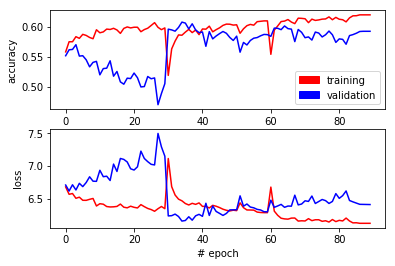

In [27]:
plot_learning_curve("vgg16_0128_2020.log")

In [236]:
ls

InceptionResNetV2/                       valid_data.bc/
InceptionResNetV2?msprop_2epoch.weights  VGG16/
inceptionV3/                             vgg16_0128_1556.h5
InceptionV3_2epoch.weights               vgg16_0128_2020.h5
InceptionV3_50epoch.weights              vgg16_0129_1326.h5
inceptionV3?msprop_2epoch.weights        vgg16_0130_0050.h5
resnet50_0130_0121.h5                    vgg16_0130_1106.h5
simple_model_sample.weights              vgg16_2epoch.weights
train_data-224.bc/                       vgg16_finetune_21epoch.weights
train_data.bc/                           vgg16.h5
train_full_data-224.bc/                  vgg16_new1.h5
valid_data-224.bc/                       vgg16_new.h5


In [238]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

model_name = "vgg16"
base_model = VGG16(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
    
predictions = Dense(120, activation='softmax')(x)
    
model = Model(inputs=base_model.input, outputs=predictions)
    
model.load_weights(model_path + "/" + model_name + '_0130_1106.h5')

In [239]:
def prepare_predictions(pred_probs):
    prepared_result = []
    max_probs = get_max_prob_per_item(pred_probs)
    for row, max_prob in zip(pred_probs, max_probs):
        prepared_result.append(np.vectorize(lambda prob: prob if prob == max_prob else 0.0)(row))
    return prepared_result

In [240]:
gen = image.ImageDataGenerator()
test_batches = gen.flow_from_directory(DATA_HOME_DIR + "test", target_size=target_size, batch_size=1, shuffle=False)

Found 10357 images belonging to 2 classes.


In [ ]:
test_batches.reset()
filenames = test_batches.filenames
test_probs = model.predict_generator(test_batches, len(filenames))

In [224]:
len(test_probs)
print np.argmax(test_probs[54])
print test_batches.filenames[54]

112
unknown/012ca7efe684c5cdfb83f35e8fbafe1b.jpg


In [154]:
def get_ids(filenames):
    return np.vectorize(lambda filename: filename[-36:-4])(filenames)

In [225]:
test_ids = get_ids(test_batches.filenames)
len(test_ids)

10357

In [136]:
train_class_indices[]

{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'

In [172]:
len(test_batches.filenames)

10357

In [226]:
header = sorted(train_class_indices.keys())
header.insert(0, "id")
header = ','.join(header)

In [227]:
result = np.c_[test_ids, np.clip(test_probs, 0.05, 0.9)]

In [228]:
np.savetxt('bugfree_clip.csv', result, delimiter=',', header=header, comments="", fmt='%s')